# EE 123 Lab 1 - Time Domain Sonar Lab

### Written by Miki Lustig and Frank Ong 2016
#### Edited, debugged, and ported to Raspberry Pi by Nick Antipa, Li-Hao Yeh, and Miki Lustig 2018
##### Updated by Alan Dong, Gautam Gunjala, and Josh Sanz 2020, Josh Sanz 2022, Drake Lin 2022

In this lab, we will interact with physical time-domain signals. The first part will involve generating and recording sounds on the Raspberry Pi. We will use a linear chirp signal to characterize the response of the speaker-microphone system and look at detecting signals using cross-correlation.
In the second part, we will build on part one and use the speaker-microphone system to develop a simple sonar.


#### Using the Raspberry Pi 

The Raspberry Pi does not have a microphone input. In order to use both audio input and output, we use a sound extension board (FE-PI AUDIO Z V2). This sound extension is in fact an Analog-to-Digital and Digital-to-Analog device. 

* connect the microphone to the mic port on the Y adaptor
* connect the Y adaptor to the HEADPHONE/MIC port on the sound extension
* connect the speaker to the speaker LINE OUT port on the sound extension
* make sure the speaker is powered (e.g. connected to a USB either on your computer, or the Pi)

<center><img src="./sonar_lab_equipment.JPG" alt="gsm" style="width: 600px;"/></center>
<center>Figure 1: Equipment connection for this lab. </center>


In [2]:
# import functions and libraries
import numpy as np, matplotlib.pyplot as plt
from matplotlib.pyplot import *
from scipy import signal
from numpy import *
import sounddevice as sd

%matplotlib inline

ModuleNotFoundError: No module named 'sounddevice'

## Part 1: Chirping!

For this assignment you will use the the Raspberry Pi equipped with a sound extension, a USB-powered speaker and a microphone. When playing a sound and recording, the signal goes through several systems. In particular it goes through the response of the sound extension output, the speaker, the room we are in, the response of the microphone, and the receive part of the sound extension.

A linear chirp is a signal in which the frequency increases linearly with time. In this assignment we will generate a chirp signal and use it to measure the amplitude of the frequency response of our speaker-room-microphone system. This lab will work best in a quiet environment. We recommend that you execute the lab at home or in a quiet place before submitting it.

An instantaneous frequency is defined as the derivative of the phase of a signal, $f(t) = \frac{1}{2\pi} \frac{d\phi (t)}{ dt} $. For example, the instantaneous frequency of $\cos(\phi(t))=\cos(2\pi f_0 t)$ is  
$$f(t) = \frac{d\phi (t)}{2\pi dt}  = f_0$$ 


For a linear chirp, the frequency changes linearly over time. The instantaneous frequency is therefore defined as 

<center>$$ f(t) = f_0 + kt. $$</center>


So,  

<center>$$ x(t) = \sin\left(2\pi\int_0^t f\left(t'\right)dt'\right) = \sin\left(2\pi\int_o^t\left(f_0+kt'\right)dt'\right) = \sin\left(2\pi\left(f_0+\frac{k}{2}t\right)t\right) $$</center>


### Part I, Task I: Generating the Chirp

Generate a 10 second long chirp signal, sampled at 48,000 Hz with a frequency range of 20 Hz to 20,000 Hz. Set the magnitude of the chirp to 0.5. This will help prevent non-linearities when we play the sound later. 

* Given $T$=total time length, $f_0$=start frequency, $f_1$ = end frequency, derive a formula $f(t)$ for the frequency sweep.
* Find the formula for the phase by integrating $\phi(t) = 2\pi\int_0^T f(t)dt$ to get the phase function.

Now, 
* Set the sample-rate frequency `fs = 48000` Hz
* **Generate a time index from `t = 0` s to `t = 10` s with sampling rate of 48,000 Hz**
* **Generate a vector of phase vs time: `phi_of_t`  (  $\phi(t)$ )**
* **Generate the chirp function `s_chirp` with amplitude of 0.5 by plugging the phase into a sinusoid.**

In [3]:
fs = 48000.0
f0 = 20.0
f1 = 20000.0
T = 10.0

# k/2 * 10 = 19980
# k/2 = 1998

# generate time index
t = np.r_[0:T:1/fs]

# generate chirp signal
k = (f1-f0) / T
phi_of_t = 2 * np.pi * (f0 + k/2 * t) * t
s_chirp = .5 * np.sin(phi_of_t)


* **Plot the first 0.5 seconds of the chirp (`s_chirp`)**, you will notice that the carrier frequency increases and that the chirp has a constant envelope. To get a nice figure, make sure the aspect ratio of the figure is height/width = 0.2 . 
* **Label the axis and figure appropriately.**

Text(0.5, 1.0, 'Chirp Amplitude vs Time')

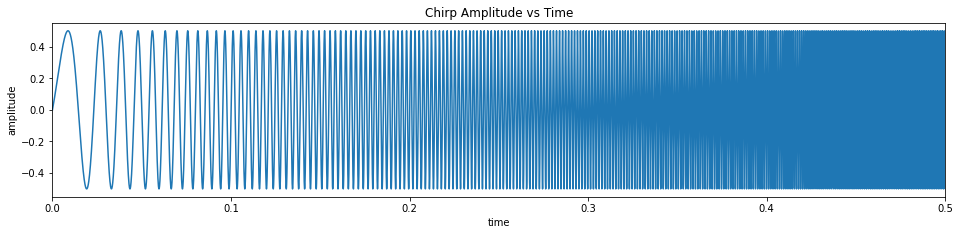

In [23]:
# set the aspect ratio such that the image is wide
width, height = figaspect(0.2)
fig = figure(figsize=(width,height))

# your code here:
plt.plot(t, s_chirp, label='chirp')
plt.xlim((0, .5))
plt.xlabel('time')
plt.ylabel('amplitude')
plt.title('Chirp Amplitude vs Time')

# end of your code

* **Plot the magnitude frequency response of the sequence from 0 to $\pi$ using the function `signal.freqz`.** Note that the digital frequency range represents a physical frequency range of 0 Hz to 24,000 Hz. To get a nice figure, make sure the aspect ratio of the figure is height/width = 0.2. 
* **Label the axis and figure appropriately.**

The `signal.freqz` function on the Pi is very slow -- be patient. 

Text(0.5, 1.0, 'Chirp magnitude freq response')

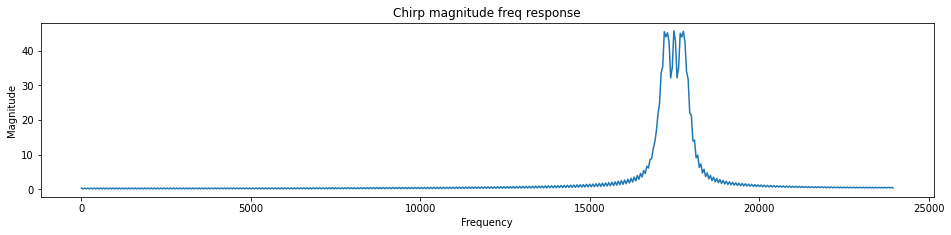

In [15]:
# generate frequency response of chirp
w, S_chirp = signal.freqz(s_chirp, 1)

# generate frequency index
# don't forget to convert from digital frequency to physical frequency
f = w / (2 * np.pi) * 48000

# plot
width, height = plt.figaspect(0.2)
fig = plt.figure(figsize=(width,height))
# your code here:

plt.plot(f, abs(S_chirp))
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.title('Chirp magnitude freq response')


* **Explain why the chirp is an appropriate signal to measure the magnitude frequency response of a system.**


#### Your answer here:

It is good because it has a relatively flat amplitude for a wide variety of frequencies, so you can then evaluate how a system relatively impacts each of the frequency ranges alltogether.


### Part I, Task II: Playing and Recording the Chirp
Now, we will play the sound of the chirp on our speaker and simultaneously record using the microphone. 

We prepared a piece of code for configuring to our setting of the sound extension that works for our system. Note that the settings for different devices may change due to different hardware performances. If it does not work on your system, use the instructions below and experiment to find a better suited one for yourself.



In [4]:
# set up alsamixer volumes for the raspberry pi

!amixer -c 1 -- sset 'Capture Mux' 'MIC_IN'
!amixer -c 1 -- sset Lineout playback unmute
!amixer -c 1 -- sset Lineout playback 100%,100%
!amixer -c 1 -- sset Mic capture 100%
!amixer -c 1 -- sset Mic playback 33%

Simple mixer control 'Capture Mux',0
  Capabilities: enum
  Items: 'MIC_IN' 'LINE_IN'
  Item0: 'MIC_IN'
Simple mixer control 'Lineout',0
  Capabilities: pvolume pswitch pswitch-joined
  Playback channels: Front Left - Front Right
  Limits: Playback 0 - 31
  Mono:
  Front Left: Playback 0 [0%] [-15.50dB] [on]
  Front Right: Playback 31 [100%] [0.00dB] [on]
Simple mixer control 'Lineout',0
  Capabilities: pvolume pswitch pswitch-joined
  Playback channels: Front Left - Front Right
  Limits: Playback 0 - 31
  Mono:
  Front Left: Playback 31 [100%] [0.00dB] [on]
  Front Right: Playback 31 [100%] [0.00dB] [on]
Simple mixer control 'Mic',0
  Capabilities: volume volume-joined
  Playback channels: Mono
  Capture channels: Mono
  Limits: 0 - 3
  Mono: 3 [100%] [40.00dB]
Simple mixer control 'Mic',0
  Capabilities: volume volume-joined
  Playback channels: Mono
  Capture channels: Mono
  Limits: 0 - 3
  Mono: 1 [33%] [20.00dB]


#### Manual setup instructions for the Raspberry Pi:

* To set up the output and input volume, in a terminal, run `alsamixer`. Make sure the card showing is: Fe-Pi Audio. (Use F6 to toggle between sound card)

You can use arrows to move between Headphone, Lineout, Mic, and capture. Use the `M` key to toggle between on (00) and Mute (MM). Use the Keys Q and Z to change the gain of the left speaker, and E and C to change the gain of the right speaker.  F4 will bring you to the page of capture configuration. 

For the sonar to work well we will need to use either the right or left speaker, but not both. Make sure the gain for one of them is 0.

For this lab, you will only need to toggle: 
* "Lineout", "Mic", "Capture Mux" tabs in the playback page
* "Mic" and "Capture" tabs in the capture page

Make sure you get good amount of volume and microphone gain to avoid low volume and saturation for proper recording.

__Playing and recording audio:__

* **Run the following code.** It is an example of how to play and record sound at the same time using the `sounddevice` package.

The resulting received sequence will be stored in the variable `rcv_chirp`.

In [7]:
# set default sample rate and number of channels. 

sd.default.samplerate = 48000
sd.default.channels = 1
sd.default.device = 'Fe-Pi Audio'
rcv_chirp = sd.playrec(s_chirp, fs, channels=1, blocking=True) # play the chirp

rcv_chirp = rcv_chirp.reshape((rcv_chirp.shape[0],)) # reshape the vector for proper transform later

In [8]:
rcv_chirp.shape

(480000,)

* **Plot the frequency response of the received sequence.**
* **Also, plot the absolute value of the received signal.** Plotting the absolute value (sort of) displays the envelope of the chirp. 
* **Label the figures and use an aspect ratio of height/width = 0.2.**


Text(0.5, 0, 'Time [s]')

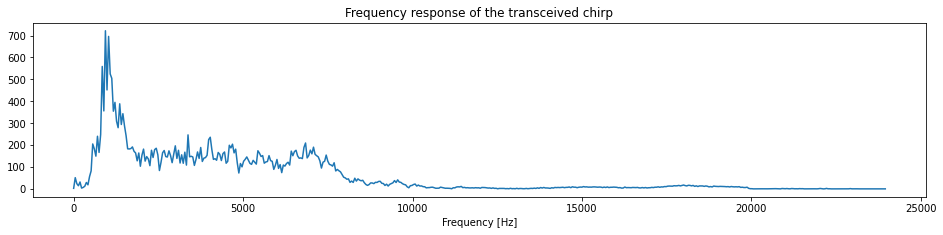

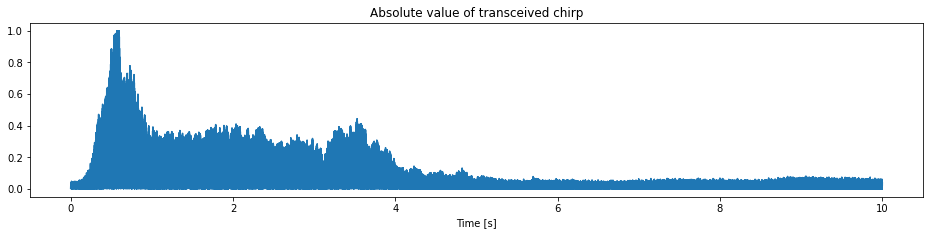

In [9]:
## plot chirp response

# generate frequency response of chirp
w, RCV_chirp = signal.freqz(rcv_chirp, 1)

# generate frequency indices
f = w / (2 * np.pi) * 48000

# generate time indices
t = np.r_[0:10:1/48000]

# plot
width, height = figaspect(0.2)
fig = figure(figsize=(width,height))
plt.plot(f, abs(RCV_chirp))
plt.title("Frequency response of the transceived chirp")
plt.xlabel("Frequency [Hz]")

fig = figure(figsize=(width,height))
plt.plot(t, abs(rcv_chirp))
plt.title("Absolute value of transceived chirp");
plt.xlabel("Time [s]")

* **Comment on the results you got.** In addition, what is the implicit assumption we are making in order to claim that the result is a frequency response? 
(HINT: consider the case when the chirp is very short)

#### Your answer here:
It looks like the the room system that modulated the chirp signal seems to preserve lower end signals better. We are also assuming that the chirp is long enough to not have any transients....?


### Part I, Task III: Envelope Detection with Hilbert Transform. 
The absolute value of the result "sort of" displays the envelope; however, it is still modulated by the (now rectified) frequency sweep carrier. If we write down the response, it can be expressed approximately as 

$$y[n] = |H[n]| \sin(2\pi (f_0 +k[n*T])nT + \angle H[n])$$

where $|H[n]|$ is the frequency response for the instantaneous frequency at the nth sample and $\angle H[n]$ is its phase response. 

The reason that it is only an approximation is that there is an inherent assumption that we do not look at transient effects, only the steady state effect for each frequency. This is a good approximation because our chirp is very slow compared to the propagation of sound in the room. 

One way to get the envelope $|H[n]|$ is to convert it to its analytic signal. The analytic signal $x_a(t)$ of signal $x(t)$ is:

$$x_a = F^{-1}(F(x)\cdot 2U) = x + j y$$

where $F$ is the Fourier transform, $U$ the unit step function,
and $y$ *is* the Hilbert transform of $x$. In other words, the negative half of the frequency spectrum is zeroed
out, turning the real-valued signal into a complex signal. This is similar to the question in HW2!

The analytic signal of the received chirp will then be: 

$$ y_a[n] = |H[n]|e^{j2\pi (f_0 +k[n*T])nT + \angle H[n]} $$

The envelope can be detected by taking the magnitude. 
(The analytic function of $y$ seems to have one more phase shift $\pi/2$ since it is a $\sin$ function.)

* **Compute the analytic signal by using the function `signal.hilbert` and plot its absolute value.** Note that the discrete Hilbert Transform is not perfect, since it uses FIR filtering. This will show up as ripple in the envelope.

* **Label the figures and use an aspect ratio of height/width = 0.2**

Text(0.5, 0, 'Time [s]')

<Figure size 1152x230.4 with 0 Axes>

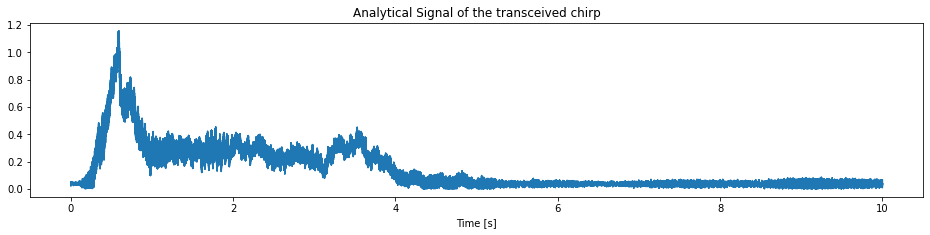

In [12]:
# your code here:
RCVa_chirp = signal.hilbert(rcv_chirp)
# end of your code

# plot
width, height = figaspect(0.2)
fig = figure(figsize=(width,height))
# your code here:

width, height = figaspect(0.2)
fig = figure(figsize=(width,height))
plt.plot(t, abs(RCVa_chirp))
plt.title("Analytical Signal of the transceived chirp")
plt.xlabel("Time [s]")


### Part I, Task IV: Autocorrelation Properties of the Chirp:

In Part II of the lab, we will be sending and receiving chirp pulses to estimate delays between the tranceived pulses. This is done by cross-correlating / matched filtering the received signal with the known chirp pulse to detect the echoes. In this task, we will investigate the correlation properties of the chirp.

A cross-correlation is defined as:

$$ R_{xy}[n] = \sum_{m=-\infty}^\infty x[m]y^*[m-n] = \left(x[m]*y^*[-m]\right)[n]$$

where $y^*[-m]$ is the complex conjugate of $y[-m]$. This is similar to a convolution, but without flipping one of the signals. It can be implemented using a convolution as shown above. In general, the more correlated the two signals are at position $n$, the higher the value will be. That's why it is useful in a sonar system.

#### Matched Filter 
When we look for a very specific shape in a signal, we can compute a cross-correlation between the signal and the shape we are interested in. In that case, the operation of the cross-correlation is also called a matched filter -- i.e. correlating with a filter that is matched to the shape we look for.

Because we will be doing cross-correlations between a chirp pulse and its echoes, it is useful to look at the autocorrelation, which is basically a cross-correlation of the signal with itself. A discrete autocorrelation of a signal is defined as: 

$$ R_{xx}[n] = \sum_{m=-\infty}^\infty x[m]x^*[m-n] = (x[m]*x^*[-m])[n]$$ 

The chirp has a very nice property that its autocorrelation is very narrow. Since the spread of the resulting correlation determines the time resolution of detection, the width of the autocorrelation is important. This property is called pulse compression and is heavily used in radar design. Random noise and some other pseudo-random sequences also possess this property.

* **Generate a 512 sample chirp pulse with a frequency sweep from 17 kHz to 18 kHz and sampling rate fs = 48000 Hz.**
* **Validate its frequency response by plotting it.**

Text(0.5, 1.0, 'Chirp magnitude freq response')

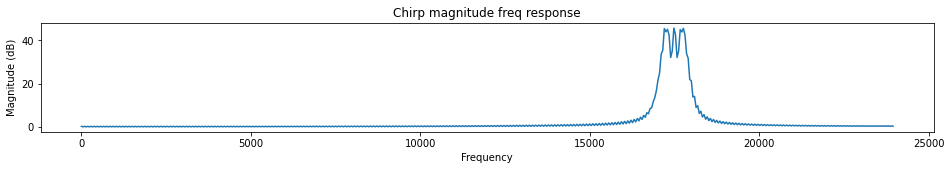

In [57]:
# declare parameters fs, N, T, t, f0, f1
# your code here
fs = 48000.0
f0 = 17000.0
f1 = 18000.0
T = 512/48000

# k/2 * 10 = 19980
# k/2 = 1998

# generate time index
t = np.r_[0:T:1/fs]

# end of your code

# generate chirp signal
# your code here:
k = (f1-f0) / T
phi_of_t = 2 * np.pi * (f0 + k/2 * t) * t
s_chirp = .5 * np.sin(phi_of_t)
# end of your code

# generate frequency response of chirp
# your code here:
w, S_chirp = signal.freqz(s_chirp, 1)
# end of your code

# generate frequency index
# your code here:
f = w / (2 * np.pi) * 48000

# end of your code

# plot
width, height = figaspect(0.1)
fig = figure(figsize=(width,height))
# your code here:

plt.plot(f, abs(S_chirp))
plt.xlabel('Frequency')
plt.ylabel('Magnitude (dB)')
plt.title('Chirp magnitude freq response')




* **Compute the autocorrelation of the chirp using discrete convolution**, either with `signal.convolve` or `signal.fftconvolve`. Remember that you have to flip the signal since convolution does that already. You can flip a signal `x` by doing `x[::-1]`. Use `mode="full"` for convolution.
* **Plot the autocorrelation.** Your plot should be spiky because we did not do envolope detection yet. Use miliseconds for the x-axis.

Text(0.5, 1.0, 'Chirp autocorrelation')

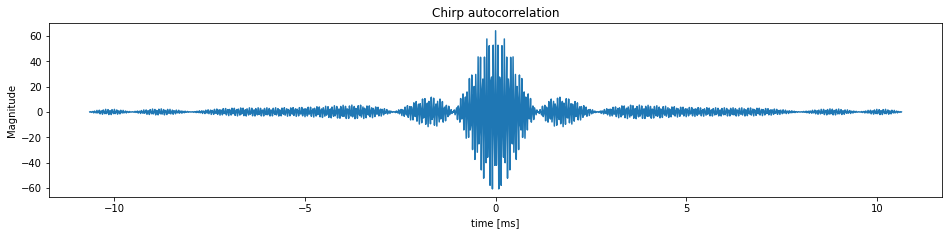

In [58]:
# compute autocorrelation
# your code here:
autocorr = signal.convolve(s_chirp, s_chirp[::-1], 'full')
t = np.r_[-511/48000:T:1/fs]*1000

# end of your code

# plot
width, height = figaspect(0.2)
fig = figure(figsize=(width,height))
# your code here:
plt.plot(t, autocorr)
plt.xlabel('time [ms]')
plt.ylabel('Magnitude')
plt.title('Chirp autocorrelation')




In a similar way to before, it is possible to recover the envelope of the autocorrelation by performing the cross-correlation with the analytic signal and then taking the absolute value. In this case, we know exactly what the analytic function is!

* **Generate `s_chirp_a`, the analytic function of the chirp** by computing: `s_chirp_a` = $e^{j\phi_t}$ . 
* **Perform the cross-correlation between `s_chirp_a` and `s_chirp` and show the envelope.** As stated before, this could also be called a matched filter. 
* For simplicity, **normalize the plot such that the maximum is 1, but record the maximum value of the autocorrelation and display it in the title of the figure.**
* **Use milliseconds for the x-axis.**
* **Measure the full-width at half max (FWHM) of the main lobe of the autocorrelation.**
* **Comment on the FWHM of the main lobe of the matched filter with respect to the duration of the pulse.** That ratio is also called pulse compression.  

It may be helpful to use the pragma ``%matplotlib notebook`` for making the figure interactive, and ``plt.grid('on')`` for displaying a grid.

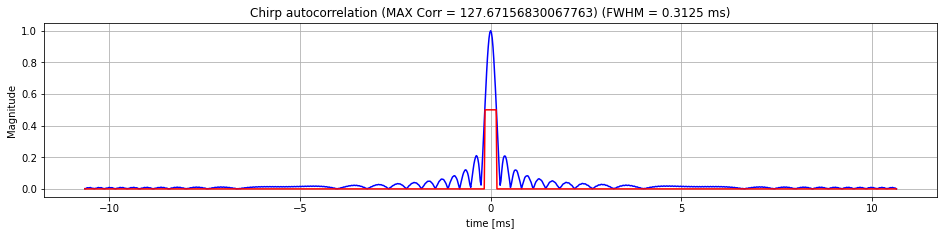

In [21]:
#%matplotlib notebook
%matplotlib inline
# your nice script to produce beautiful chirps, cross-correlations, and figures below:

# compute autocorrelation and envelope
# your code here:
k = (f1-f0) / T
phi_of_t = 2 * np.pi * (f0 + k/2 * t) * t
s_chirp = .5 * np.sin(phi_of_t)

s_chirp_a = np.exp(1j*phi_of_t)
autocorr = signal.convolve(s_chirp_a, s_chirp[::-1], 'full')
t = np.r_[-511/48000:T:1/fs]*1000

# normalize
max_correlation = max(abs(autocorr))
autocorr = abs(autocorr)/max_correlation

fwhm = [.5 if x > .5 else 0 for x in autocorr]
fwhm_width = np.count_nonzero(fwhm) / fs * 1000

# end of your code

# plot
width, height = figaspect(0.2)
fig = figure(figsize=(width,height))
# your code here:
plt.plot(t, autocorr, color='b')
plt.plot(t, fwhm, color='r')
plt.xlabel('time [ms]')
plt.ylabel('Magnitude')
plt.title(f'Chirp autocorrelation (MAX Corr = {max_correlation}) (FWHM = {fwhm_width} ms)')
plt.grid('on')

#### Your answer here:



Now we will look at why the chirp pulse is better for cross-correlation detection than a pure tone.
- **Repeat Task IV for:**
 1. A constant frequency of 17,000 Hz, 512 samples in length. 
 2. A chirp with a frequency sweep from 16,500 Hz to 17,500 Hz (1 kHz bandwidth), 512 samples in length.  
 3. A chirp with a frequency sweep from 15,000 Hz to 19,000 Hz (4 kHz bandwidth), 512 samples in length.
- **Compare the widths of the main lobes** (full width at half max). How much "Pulse Compression" are you getting by using a chirp for detection compared to a single frequency pulse?
- **What is the approximate bandwidth of the pure frequency pulse and what is the bandwidth of the chirp pulses? Comment on the tradeoff between bandwidth and pulse compression.**
- **What is the maximum autocorrelation for each pulse?**
   

<Figure size 1152x230.4 with 0 Axes>

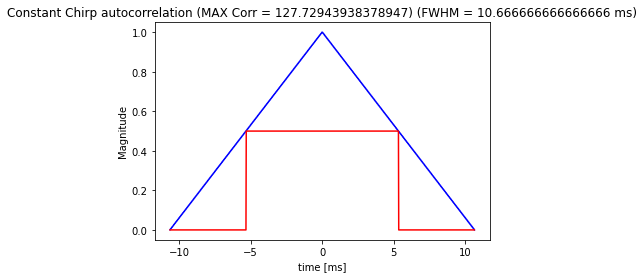

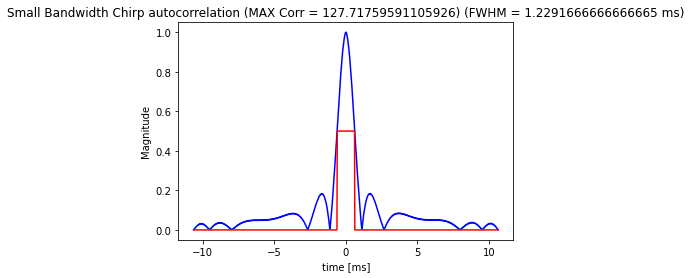

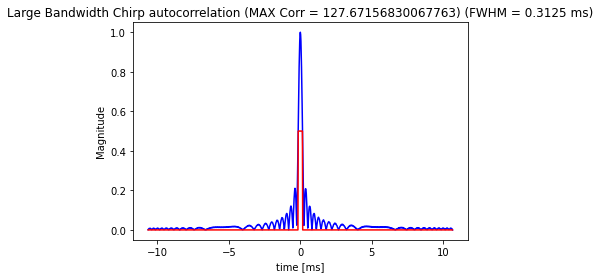

In [25]:
%matplotlib inline
# declare fs, N, T, t parameters
# your code here:
fs = 48000.0
f0 = 16500.0
f1 = 17500.0
N = 512
T = N/48000
t = np.r_[0:T:1/fs]
# end of your code

def autocorrelate(s, phi_of_t, fs=fs, N=N):
    s_a = np.exp(1j*phi_of_t)
    s_auto = signal.convolve(s_a, s[::-1], 'full')
    t2 = np.r_[-(N-1)/fs:T:1/fs]*1000

    # normalize
    s_auto = abs(s_auto)
    max_corr = max(s_auto)
    s_auto = s_auto/max_corr

    fwhm = [.5 if x > .5 else 0 for x in s_auto]
    fwhm_width = np.count_nonzero(fwhm) / fs * 1000
    return s_auto, fwhm, t2, max_corr, fwhm_width

# generate pure tone
# your code here:
k = (f1-f0) / T
phi_of_t = 2 * np.pi * 17000 * t
const = .5 * np.sin(phi_of_t)

const_auto, const_fwhm, t2, const_max_corr, const_fwhm_width = autocorrelate(const, phi_of_t)

# end of your code

# generate lower bandwidth chirp signal
# your code here:
k = (f1-f0) / T
phi_of_t = 2 * np.pi * (f0 + k/2 * t) * t
s_chirp = .5 * np.sin(phi_of_t)
s_auto, s_fwhm,  t2, s_max_corr, s_fwhm_width = autocorrelate(s_chirp, phi_of_t)
# end of your code

# generate higher bandwidth chirp signal
# your code here:
f0 = 15000.0
f1 = 19000.0
k = (f1-f0) / T
phi_of_t = 2 * np.pi * (f0 + k/2 * t) * t
s_chirp_wide = .5 * np.sin(phi_of_t)
wide_auto, wide_fwhm, t2, wide_max_corr, wide_fwhm_width = autocorrelate(s_chirp_wide, phi_of_t)
# end of your code

# plot
width, height = figaspect(0.2)
fig = figure(figsize=(width,height))
# your code here:
def plotautocorrelation(s_auto, fwhm, t, max_corr, fwhm_width, titleMod=""):
    plt.figure()

    plt.plot(t, s_auto, color='b')
    plt.plot(t, fwhm, color='r')
    plt.xlabel('time [ms]')
    plt.ylabel('Magnitude')
    plt.title(titleMod + f'Chirp autocorrelation (MAX Corr = {max_corr}) (FWHM = {fwhm_width} ms)')

plotautocorrelation(const_auto, const_fwhm, t2, const_max_corr, const_fwhm_width, "Constant ")
plotautocorrelation(s_auto, s_fwhm,  t2, s_max_corr, s_fwhm_width, "Small Bandwidth ")
plotautocorrelation(wide_auto, wide_fwhm,  t2, wide_max_corr, wide_fwhm_width, "Large Bandwidth ")


#### Your answer here:

Now we will look at why the chirp pulse is better for cross-correlation detection than a pure tone.
- **Compare the widths of the main lobes** (full width at half max). How much "Pulse Compression" are you getting by using a chirp for detection compared to a single frequency pulse?

By using a chirp for detection, we are getting more than 10fold pulse compression, and much better approximation of a dirac pulse.

- **What is the approximate bandwidth of the pure frequency pulse and what is the bandwidth of the chirp pulses? Comment on the tradeoff between bandwidth and pulse compression.**

The approx bandwidth of pure frequency is 10 ms and the bandwidth of the chirps are 1.2ms and .3 ms

- **What is the maximum autocorrelation for each pulse?**

Max autocorrelation for pulses is 127 about.


Now:
- **Repeat Task IV** for a chirp with a frequency sweep from 16,500 Hz to 17,500 Hz, 256 samples in length
- **Compare the width of the main lobe** (full width at half max) to the previous case of 16,500 Hz - 17,500 Hz, 512 samples in length.
- **Compare the maximum autocorrelation values as well.**
- **Explain the effect of having more bandwidth. What's the effect of having longer/shorter pulses?**


<Figure size 960x288 with 0 Axes>

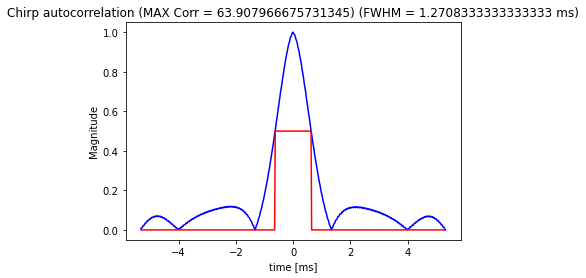

In [27]:
# declare parameters
# your code here:
fs = 48000.0
f0 = 16500.0
f1 = 17500.0
N = 256
T = N/48000
t = np.r_[0:T:1/fs]

# end of your code

# generate chirp signal
# your code here:
k = (f1-f0) / T
phi_of_t = 2 * np.pi * (f0 + k/2 * t) * t
s_chirp = .5 * np.sin(phi_of_t)
s_auto, s_fwhm,  t2, s_max_corr, s_fwhm_width = autocorrelate(s_chirp, phi_of_t, fs, N)

# end of your code

# plot
width, height = figaspect(0.3)
fig = figure(figsize=(width,height))
# your code here:

plotautocorrelation(s_auto, s_fwhm,  t2, s_max_corr, s_fwhm_width)

####  Your answer here:

- **Compare the width of the main lobe** (full width at half max) to the previous case of 16,500 Hz - 17,500 Hz, 512 samples in length.
The width of the main lobe in this case is the same width compared to the lobe of the previous question where the frequency range is the same. This suggests that lobe width is a function of the bandwidth.

- **Compare the maximum autocorrelation values as well.**

The maximum autocorrelation seems to be half of the height of the correlation of a 512 sample chirp. This suggests that the height is a function of thenumber of samples, which makes sense looking at the autocorellation function.

- **Explain the effect of having more bandwidth. What's the effect of having longer/shorter pulses?**

Having more bandwidth, will give us a thinner pulse.


### Dealing with sidelobes
As you can see, the chirp provides good pulse compression of the main lobe. However, there the sidelobes are very strong. This is because the chirp is multiplied with a rect function; the cutoff is abrupt. Instead, we will window the chirp with one of the smooth window functions to taper off the sidelobes.

* **Repeat the cell above** for a 512-length chirp with a sweep from 16.5 kHz to 17.5 kHz, and from 15 kHz to 19 kHz. **This time, multiply the chirp (and its analytic function) with a Hann window.** You will find the function `signal.hann` useful. 

* **Plot the normalized autocorrelations** (in the same figure).
* **Comment on the magnitude of the sidelobes.**
* **Comment on the width of the main lobes.**
* **What's the tradeoff?**


<Figure size 960x288 with 0 Axes>

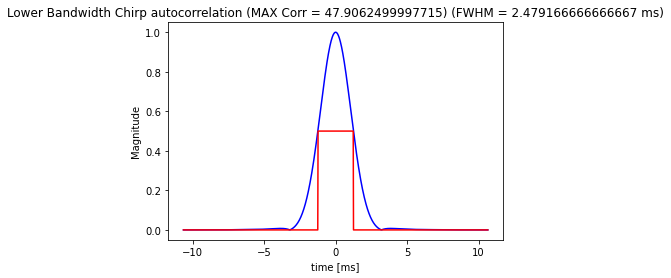

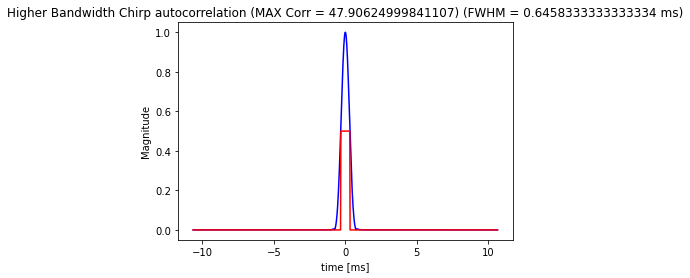

In [29]:
# declare parameters
# your code here:
fs = 48000.0
N = 512
T = N/48000
t = np.r_[0:T:1/fs]
# end of your code


def autocorrelateHann(s, phi_of_t, fs=fs, N=N):
    s_a = np.exp(1j*phi_of_t) * signal.hann(N)
    s = s * signal.hann(N)
    s_auto = signal.convolve(s_a, s[::-1], 'full') 
    t2 = np.r_[-(N-1)/fs:T:1/fs]*1000

    # normalize
    s_auto = abs(s_auto)
    max_corr = max(s_auto)
    s_auto = s_auto/max_corr

    fwhm = [.5 if x > .5 else 0 for x in s_auto]
    fwhm_width = np.count_nonzero(fwhm) / fs * 1000
    return s_auto, fwhm, t2, max_corr, fwhm_width


# generate lower bandwidth chirp signal
# your code here:
f0 = 16500.0
f1 = 17500.0
k = (f1-f0) / T
phi_of_t = 2 * np.pi * (f0 + k/2 * t) * t
s_chirp = .5 * np.sin(phi_of_t)
s_auto, s_fwhm,  t2, s_max_corr, s_fwhm_width = autocorrelateHann(s_chirp, phi_of_t, fs, N)

# end of your code

# generate higher bandwidth chirp signal
# your code here:
f0 = 15000.0
f1 = 19000.0
k = (f1-f0) / T
phi_of_t = 2 * np.pi * (f0 + k/2 * t) * t
s_chirp_wide = .5 * np.sin(phi_of_t)
w_auto, w_fwhm,  t2, w_max_corr, w_fwhm_width = autocorrelateHann(s_chirp_wide, phi_of_t, fs, N)

# end of your code

# plot
width, height = figaspect(0.3)
fig = figure(figsize=(width,height))
# your code here:

plotautocorrelation(s_auto, s_fwhm,  t2, s_max_corr, s_fwhm_width, "Lower Bandwidth ")
plotautocorrelation(w_auto, w_fwhm,  t2, w_max_corr, w_fwhm_width, "Higher Bandwidth ")

#### Your answer here:

* **Comment on the magnitude of the sidelobes.**

The magnitude of the sidelobes is nearly gone now.

* **Comment on the width of the main lobes.**

The width of the main lobe is about twice as wide now though.

* **What's the tradeoff?**

There is a tradeoff between the existence of side lobes and a sacrifice in the height and the width of the main side lobe.


## Part II: Sonar


In this part of the lab we will write a simple application that implements a sonar using the Raspberry Pi and a speaker and microphone.

The basic idea is very simple and is the basis of sonar and ultrasound imaging -- objects reflect sound waves. If we send a pulse of sound, we will get reflected echoes of that pulse. Detecting the echoes and their time-of-flight will reveal their distance from the source, based on the speed of sound in air. 

The way we are going to implement the sonar is to generate a series of rapid pulses, and then use matched filtering to detect the returning echoes. There are many parameters in this lab that can be tweaked to get different results. We encourage you to experiment. We very much enjoyed making the lab and played quite a bit! We hope you enjoy it too. 

#### Instructions for Raspberry Pi:
The microphone and speaker you have are somewhat directional. Make sure that the microphone and speaker point in the same direction. You will get the best quality in a quiet room, without interference from other sources of noise -- especially from your fellow students playing chirp pulses at the same time as you are!

If you are getting poor results, please consult with us. 

This lab was inspired by an iPhone app called active-radar.


### Part II, Task I: Generating Chirp Pulses

Recall from Part I that the width of the main lobe of the autocorrelation depends on the bandwidth of the pulse. 
For a constant frequency pulse (i.e. a pure tone), the bandwidth will be inversely proportional to its length. Short pulses are localized in time, and therefore we will be able to separate echoes from targets that are closely spaced. However, short pulses carry less energy (for the same amplitude) and this will reduce our signal-to-noise ratio (SNR) during detection. So, in summary: for constant frequency pulses, there's an inherent tradeoff between the resolution of the sonar (distinguishing between neighboring targets) and the signal-to-noise ratio.

If we use a chirp pulse, we can increase the duration of the pulse while also increasing the bandwidth. This will enable us to improve our SNR while maintaining the resolution of our sonar (by preserving a large bandwidth).

In our implementation we are going to design a pulsed sonar system in which we repeatedly send pulses and then listen to the returning echoes. The arrival time of the echoes will correspond to double the time-of-flight of sound propagation from our system to the target. 

* **Write a function that generates a chirp pulse:**
`pulse = genChirpPulse(Npulse, f0, f1, fs)`.

The function will accept: 
- `Npulse` = number of samples, 
- `f0, f1` = starting and ending frequency, and 
- `fs` = sampling rate. 

The function will return the analytic function of the chirp $\exp \left(j 2\pi \int_0^t f(t)dt \right)$ with amplitude 1.

In [32]:
def genChirpPulse(Npulse, f0, f1, fs):
    # Function generates an analytic function of a chirp pulse
    # Inputs:
    #     Npulse = pulse length in samples
    #     f0     = starting frequency of chirp
    #     f1     = end frequency of chirp
    #     fs     = sampling frequency
    # Output:
    #     pulse  = chirp pulse
    
    # your code here:
    T = Npulse/fs
    t = np.r_[0:Npulse/fs:1/fs]
    k = (f1-f0) / T
    phi_of_t = 2 * np.pi * (f0 + k/2 * t) * t

    pulse = np.exp(1j * phi_of_t)
    
    # end of your code
    
    return pulse


* To validate that the function works **display the pulse generated with `Npulse = 200`, `f0 = 1000`, `f1 = 8000`, `fs = 48000`.** Remember the pulse is complex, so plot the real and imaginary parts separately.

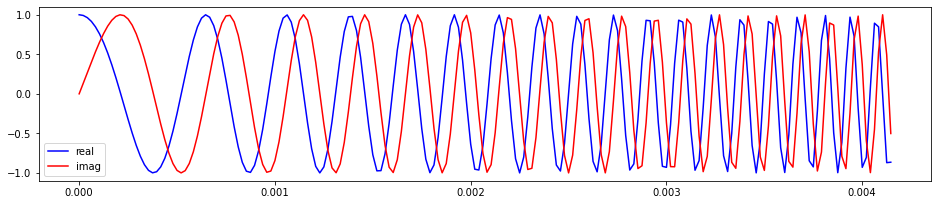

In [34]:
%matplotlib inline

# your code here:
Npulse = 200
f0 = 1000
f1 = 8000
fs = 48000
pulse = genChirpPulse(Npulse, f0, f1, fs)
t = np.r_[0:Npulse/fs:1/fs]
# end of your code

# plot
width, height = figaspect(0.2)
fig = figure(figsize=(width,height))
# your code here:
plt.plot(t, np.real(pulse), color='b', label='real')
plt.plot(t, np.imag(pulse), color='r', label='imag')
plt.legend()


__Generate Pulse Trains__

Next, we will use the pulse generated by `genChirpPulse` and generate a pulse train.

* **Write a new function `ptrain = genPulseTrain(pulse, Nrep, Nseg)`**
that accepts 
- `pulse` = a pulse generated by `genChirpPulse`,  
- `Nrep` = number of pulse repetitions, and
- `Nseg` = length of each pulse train segment (which is >= to the length of `pulse`).

The function returns `ptrain` which is a vector of length `Nrep * Nseg`. 

(Hint: use `np.tile`.)

In [40]:
def genPulseTrain(pulse, Nrep, Nseg):
    # Function generates a pulse train from a pulse. 
    # Inputs:
    #     pulse  = the pulse generated by genChirpPulse
    #     Nrep   = number of pulse repetitions
    #     Nseg   = length of pulse segment >= len(pulse)
    # Output:
    #     ptrain = pulse train
    
    # your code here:
    if Nseg > len(pulse):
        pulse = np.hstack((pulse, np.zeros(Nseg - len(pulse))))
    ptrain = np.tile(pulse, Nrep)
    # end of your code
    
    return ptrain

# testing that it works as expected
print(genPulseTrain(np.array([1,2,3]), 5, 4))

[1. 2. 3. 0. 1. 2. 3. 0. 1. 2. 3. 0. 1. 2. 3. 0. 1. 2. 3. 0.]


### Part II, Task II: Record Echoes of Chirp Pulse Train

We now have components to generate pulses, generate a pulse train, and play and record it. Let's see what we get!
We will start with very short pulses with a single carrier frequency. Rectangular pulses are difficult for the speaker
to produce as they exhibit discontinuities at the beginning and the end of the pulse. Therefore we will multiply the pulses
with a smooth window. Here, we will use a Hann window.

* Generate a `f0` = `f1` = 8 kHz, `Npulse` = 96 pulse with `fs` = 48000. Window the pulse with a Hann window. This will result in a pulse length of 2 ms. You should be able to hear this tone.
* Plot the real and imaginary parts of the pulse.

In [19]:
fs = 48e3
f0 = 8e3
f1 = 8e3
Npulse = 96

# your code here:

# end of your code

# plot
width, height = figaspect(0.2)
fig = figure(figsize=(width,height))
# your code here:



* Use the real part of the pulse to generate a pulse train of `Nrep` = 15 pulses, `Nseg` = 4096 samples.

In [20]:
# your code here:



* **Play and record the pulse train.** Scale the amplitude of the pulses to 0.5. Make sure your volume is set to a maximum of 70% and look at the plot with the input pulse train and the received pulse train.

Use the pragma ``%matplotlib notebook`` for interactive plots, so you can zoom in on the result.

In [21]:
!amixer -c 1 -- sset Lineout playback 100%,100%
!amixer -c 1 -- sset Mic capture 100%
!amixer -c 1 -- sset Mic playback 33%

In [22]:
rcv = sd.playrec(ptrain/2.0, fs, channels=1, blocking=True)
rcv = rcv.reshape((rcv.shape[0],))

In [23]:
%matplotlib notebook
%matplotlib notebook

# plot
width, height = figaspect(0.3)
fig = figure(figsize=(width,height))
# your code here:



* **Extract a single pulse from the received pulse train.** You can find the starting index of the pulse from the interactive plot. Extract at least `2*Npulse` samples before the starting index and `20*Npulse` samples after using `rcv_pulse = rcv[idx-2*Npulse:idx+Npulse*20]`
* **Plot the received pulse.** Can you see any echoes?

You can disable interactivity using the pragma ``matplotlib inline``.


In [24]:
%matplotlib notebook
%matplotlib notebook


# find index of start pulse
# your code here:

# end of your code

# plot
width, height = figaspect(0.2)
fig = figure(figsize=(width,height))
# your code here:



#### Matched Filtering

The strong pulses we see are a result of direct feedthrough from the transmitter to the receiver that do not scatter off targets. The echoes we see are a result of echoes from reflecting surfaces. The problem in our setup is that we don't know the exact delay between the transmitter and the receiver. Instead, we will assume that the travel time for sound between the speaker and the microphone is negligible and much smaller than that of reflective targets. We can then detect when the pulses start based on the direct feedthrough signal. This assumption is very good as long as your speaker is close to the microphone!

We will detect both the feedthrough and echoes using matched filtering.

* **Write a function `Xrcv = crossCorr(rcv, pulse_a)`** to calculate the cross-correlation (matched filter) of the received signal with the analytic function of the pulse.  You can use `signal.convolve` or `signal.fftconvolve`.
* **Take the absolute value of `Xrcv` to recover its envelope.** Call the result `Xrcv_a`.

Make sure the plot is interactive with ``matplotlib notebook``.

In [25]:
def crossCorr(rcv, pulse_a):
    # Funtion generates cross-correlation between rcv and pulse_a.
    # Inputs:
    #     rcv     = received signal
    #     pulse_a = analytic pulse
    # Output:
    #     Xrcv    = cross-correlation between rcv and pulse_a
    
    # your code here:

    # end of your code
    
    return Xrcv

In [26]:
%matplotlib notebook
%matplotlib notebook

# your code here:



* Again, extract a single pulse from the received pulse train using the same index. Extract at least `2*Npulse` samples before the pulse and `20*Npulse` samples after. Plot the received pulse. Can you see any echoes?

In [27]:
%matplotlib notebook
%matplotlib notebook

# find index of start pulse
# your code here:

# end of your code

# plot
width, height = figaspect(0.2)
fig = figure(figsize=(width,height))
# your code here:



#### Sonar System

In order to automate the system and visualize the results we need a few more components. To extract the pulses we need to know the position of the first feedthrough pulse. 


* **Write a function `ind = findDelay(Xrcv_a, Nseg)`** that takes the result of the matched filter and finds the index of the first feedthrough pulse. Try testing on the actual signal to check whether the function is correct. There are multiple ways of doing it. `Nseg` is not necessarily required.

In [28]:
def findDelay(Xrcv, Nseg):
    # Function finds the first pulse index.
    # Inputs:  
    #     Xrcv = the received matched filtered signal
    #     Nseg = length of a segment
    # Output:
    #     ind  = index of the beginning of the first pulse
    
    # your code here:

    # end of your code
    
    return ind

In [29]:
ind = findDelay(Xrcv_a, Nseg)
print(ind)

We now can correct for delays and detect echoes. The only thing left now is to convert the time between echoes into actual distance.

If we send a pulse of sound, we will get reflection echoes of that pulse. Detecting the echoes and their time-of-flight will reveal their distance from the source, based on the speed of sound in air. The speed of sound in air is given by the following equation:

$$ v_s = 331.5\sqrt{1+T/273.15}~\mathrm{m/s}$$ 

where T is the temperature in degrees Celcius. 

* **Create a function `t = dist2time(dist, temperature)`** that takes in the distance to the target in cm and converts it into the time in seconds between the transmitted pulse and its echo. Remember the arrival time includes the time to the target and back and therefore the time should be doubled. 
For example, for `temperature` = 20 degrees Celsius and `dist` = 400 cm, the time it takes is 0.023 s.

* **Create a function `dist = time2dist(t, temperature)`** that takes in the time to the target in seconds and converts it into the distance in cm between the transmitted pulse and its echo. Remember the arrival time includes the time to the target and back and therefore the time should be halved. 

In [30]:
def dist2time(dist, temperature=21.0):
    # Function converts distance in cm to time in seconds.
    # Inputs:
    #     dist        = distance to object in cm
    #     temperature = in Celcius
    # Output:
    #     t           = time in seconds between transmitted pulse and echo
    
    # your code here:

    # end of your code
    
    return t

def  time2dist(t, temperature=21.0):
    # Function converts time in seconds to distance in cm.
    # Inputs:
    #     t           = time in seconds between transmitted pulse and echo
    #     temperature = in Celcius
    # Output:
    #     dist        = distance to object in cm
    
    # your code here:

    # end of your code
    
    return dist

## A sonar (almost)

* The following function will use your functions to generate pulses and display the matched filtering of each pulse as intensity of a horizontal line in an image. If nothing is moving, you will be able to see constant vertical lines representing echoes. If something is moving, you will be able to track the object's distance.  



In [31]:
def sortOfASonar(Npulse, f0, f1, fs, Nrep, Nseg):
    pulse_a = genChirpPulse(Npulse, f0, f1, fs) * signal.hann(Npulse)
    pulse = pulse_a.real
    ptrain = genPulseTrain(pulse, Nrep, Nseg)
    rcv = sd.playrec(ptrain/2.0, fs, channels=1, blocking=True)
    rcv = rcv.reshape((rcv.shape[0],))
    Xrcv_a = abs(crossCorr(rcv, pulse_a))
    
    ind = findDelay(Xrcv_a, Nseg) 
    img = np.zeros((Nrep-1,Nseg))
    img[0,:] = Xrcv_a[ind:ind+Nseg]
    
    # Look for peak in each pulse in the pulse train to avoid drift between transmit and receive
    for n in range(1, Nrep-1):
        ind2 = findDelay(Xrcv_a[ind+Nseg//2:ind+Nseg//2+Nseg], Nseg)
        ind = ind + ind2 + Nseg//2
        img[n,:] = Xrcv_a[ind:ind+Nseg]
    
    return img

Now, use the function above to:  

* **Generate a pulse train of 100 pulses.** Each (Hann windowed) pulse should be length `Npulse = 72` samples (1.5 ms) and a constant frequency of 8 kHz. The spacing between pulses should be 0.1 seconds (`Nseg = 4800`). 
* **Display the image.**

Note: you don't actually have to write any code for this section, we just want you to use everything you wrote about to see the sonar system come together.

In [32]:
Npulse = 72
f0 = 8e3
f1 = 8e3
fs = 48e3
Nrep = 100
Nseg = 4800
img = sortOfASonar(Npulse, f0, f1, fs, Nrep, Nseg)

Display the result. Pay attention to the width of the echoes. 

In [ ]:
%matplotlib notebook
%matplotlib notebook

# display up to 2.5 m, approximately 700 samples at 48000 Hz sampling rate (and 21 degrees C)

vmax = 0.25 # threshold -- lower will be able to see smaller echoes

plt.imshow(img[:,0:700]/max(img.ravel()), vmax=vmax, aspect=10, cmap='gray', interpolation='bilinear', extent=(0,time2dist(700/fs), Nrep*Nseg/fs, 0))
plt.xlabel('Distance [cm]')
plt.ylabel('Time [s]')

Now:
* **Repeat the experiment with a chirp length of `Npulse = 360` samples, and a frequency sweep from 6 kHz to 12 kHz.**

Pay attention to the resolution of the lines. 

In [ ]:
Npulse = 360
f0 = 6000.0
f1 = 12000.0
fs = 48000.0
Nrep = 100
Nseg = 4800
img = sortOfASonar(Npulse, f0, f1, fs, Nrep, Nseg)

In [ ]:
%matplotlib notebook
%matplotlib notebook

# display up to 2.5 m, approximately 700 samples at 48000 Hz sampling rate (and 21 degrees C)

vmax = 0.25 # threshold -- lower will be able to see smaller echoes

plt.imshow(img[:,0:700]/max(img.ravel()), vmax=vmax, aspect=10, cmap='gray', interpolation='bilinear', extent=(0,time2dist(700/fs), Nrep*Nseg/fs, 0))
plt.xlabel('Distance [cm]')
plt.ylabel('Time [s]')

Feel free to repeat while moving a target -- can you see the echoes changing? Try playing with different parameters. 




## A Real (Time) Sonar
You now have a working sonar! It would be much easier though to play with different parameters if we automate things, so we created some wrappers for real-time plotting in a separate notebook (lab1-part3-RealTime-Sonar). 

* **Copy-and-paste the 5 functions you created, including `genPulseTrain()`, `genChirpPulse()`, `crossCorr()`, `findDelay()`, and `dist2time()`, to the specified code cell in the Real-Time Sonar Lab.**


### You are now ready to proceed to the Real-Time Sonar Lab!